# Fake reviwe Detection

1. Dataset

we have the original review datset from on a publicly available source now we will use T5 Model to generate the fake review and shuffle oth the datasets and store them as a csv file

In [ ]:
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from tqdm import tqdm
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def load_t5_model():
    """Load T5 model with error handling"""
    try:
        # Use smaller model for faster execution
        model_name = 't5-small'
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name)

        # Move to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Load dataset
try:
    original_df = pd.read_csv('test.csv')
    original_df['label'] = 'OG'  # Original reviews
except FileNotFoundError:
    print("Error: 'test.csv' not found in current directory")
    raise

# Initialize T5 model
try:
    model, tokenizer, device = load_t5_model()
except:
    print("Failed to initialize T5 model")
    raise

def generate_t5_review(product_id, original_df, max_length=80):
    """Generate a fake review using T5 model with error handling"""
    try:
        # Get product context
        product_reviews = original_df[original_df['item_id'] == product_id]['review']
        example_review = product_reviews.sample(1).iloc[0] if len(product_reviews) > 0 else "a product"

        input_text = f"generate a fake product review similar to: {example_review[:200]}"  # Limit context length

        inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=max_length,
                do_sample=True,
                temperature=0.9,  # Higher temperature for more creativity
                top_k=50,
                top_p=0.95,
                num_return_sequences=1
            )

        review = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Post-processing
        review = review.split('.')[0] + '.'
        review = review.replace('"', '').strip()

        return review if len(review) > 10 else "Excellent product, works perfectly."

    except Exception as e:
        print(f"Error generating review for product {product_id}: {e}")
        return "Great product, highly recommended."

# Generate fake reviews
fake_reviews = []
unique_products = original_df['item_id'].unique()

try:
    for i, product_id in enumerate(tqdm(unique_products[:len(original_df)], desc="Generating reviews")):
        review_text = generate_t5_review(product_id, original_df)

        fake_reviews.append({
            'qid': len(original_df) + i + 1,
            'item_id': product_id,
            'user_id': f"T5USER{i+1:04d}",
            'rating': min(5, max(1, int(np.random.normal(4.2, 0.8)))),
            'review': review_text,
            'label': 'CG'  # Computer Generated
        })
except Exception as e:
    print(f"Error during review generation: {e}")

# Create DataFrame and combine
if fake_reviews:
    fake_df = pd.DataFrame(fake_reviews)
    combined_df = pd.concat([original_df, fake_df])

    # Shuffle the dataset
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save to CSV
    combined_df.to_csv('t5_generated_reviews.csv', index=False)
    print(f"Successfully generated dataset with {len(original_df)} real and {len(fake_df)} fake reviews")
else:
    print("Failed to generate any fake reviews")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generating reviews: 100%|██████████| 20463/20463 [7:14:40<00:00,  1.27s/it]


Successfully generated dataset with 21223 real and 20463 fake reviews


In [ ]:
!pip install pandas numpy torch transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [ ]:
!pip install torch==2.0.1 transformers==4.30.2 pandas numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 833.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. Load the requied modules

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

3. Data Preprocessing
now we will load the data and perform the EDA

In [2]:
data = pd.read_csv("/content/t5_generated_mixed.csv")

In [3]:
data.head()

,qid,item_id,user_id,rating,review,label
0,23267,B0BNB1XTYY,T5USER2044,4,"Excellent product, works perfectly.",CG
1,15031,B09FSFGM8C,AGI3P42W4XXWUVZDY6AAAUBT7COA,5,heart warming It was nice to see that a man ca...,OG
2,12430,B0B59QBY9G,AEHC7E4QIJN72QKBVSMW3QOTT4JA,5,OMG I love these I got these for my computer a...,OG
3,39805,B09LV2WPF6,T5USER18582,3,", looks perfect All parts fit and directions w...",CG
4,12880,B0B822YLNY,AHMLRDLKVDAJ3EBXQUROJWHMSTGQ,5,Perfect Socks! I love these socks! They are so...,OG


<ipython-input-4-8eac74b2a30a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratingcount.index, y=ratingcount.values, palette='viridis')


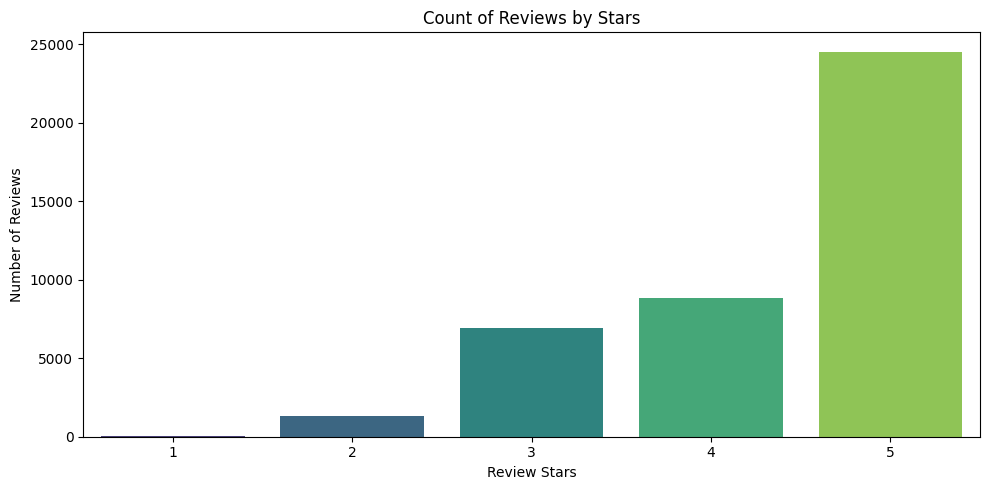

In [4]:

ratingcount = data['rating'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=ratingcount.index, y=ratingcount.values, palette='viridis')

plt.title('Count of Reviews by Stars')
plt.xlabel('Review Stars')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()


In [5]:
data.shape
print(data.info())
print(data.describe())
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41686 entries, 0 to 41685
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   qid      41686 non-null  int64 
 1   item_id  41686 non-null  object
 2   user_id  41686 non-null  object
 3   rating   41686 non-null  int64 
 4   review   41686 non-null  object
 5   label    41686 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None
                qid        rating
count  41686.000000  41686.000000
mean   20842.990884      4.354867
std    12034.288874      0.876676
min        0.000000      1.000000
25%    10421.250000      4.000000
50%    20842.500000      5.000000
75%    31264.750000      5.000000
max    41686.000000      5.000000
qid        0
item_id    0
user_id    0
rating     0
review     0
label      0
dtype: int64


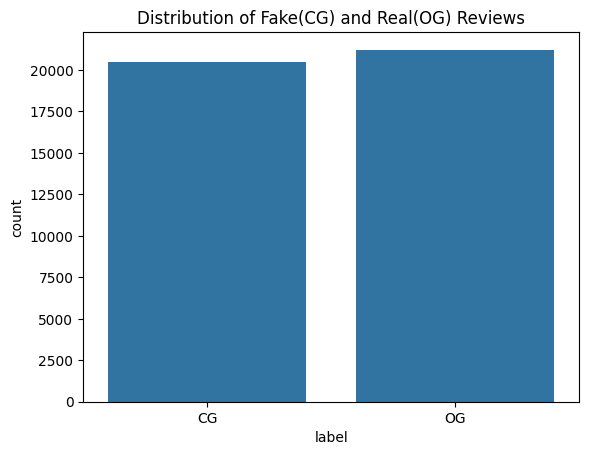

label
OG    0.509116
CG    0.490884
Name: proportion, dtype: float64


In [6]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Fake(CG) and Real(OG) Reviews')
plt.show()

print(data['label'].value_counts(normalize=True))


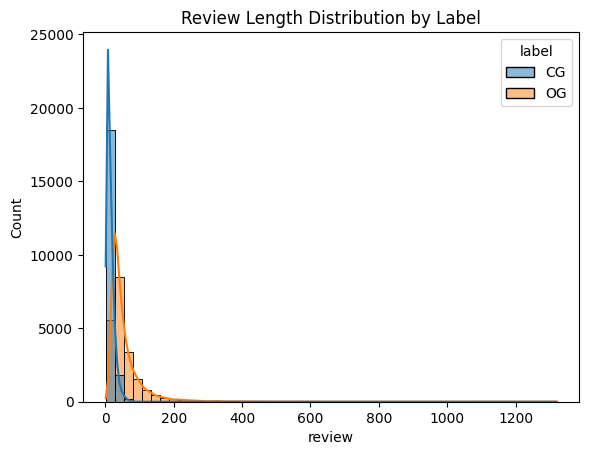

In [7]:

sns.histplot(data=data, x=data['review'].apply(lambda x: len(str(x).split())), hue='label', bins=50, kde=True)
plt.title('Review Length Distribution by Label')

plt.show()


All the feature in our dataset are very important for making business decisions but for this project we need only specific feature do we will drop the other un necessary ones

In [8]:
#droping the unwanted features
df = data.drop(columns=['item_id','qid', 'user_id', 'review_length', 'rating'], errors='ignore')
df.head()

,review,label
0,"Excellent product, works perfectly.",CG
1,heart warming It was nice to see that a man ca...,OG
2,OMG I love these I got these for my computer a...,OG
3,", looks perfect All parts fit and directions w...",CG
4,Perfect Socks! I love these socks! They are so...,OG


In [14]:

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def clean_text(text):
    #Convert to string and lowercase
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()

    #Remove URLs and HTML tags early
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<[^>]*>', '', text)

    #Tokenize by splitting on spaces
    tokens = text.split()

    #Remove digits and punctuation tokens
    cleaned_tokens = []
    for word in tokens:
        word = word.translate(str.maketrans('', '', string.punctuation))
        if word.isalpha() and word not in stop_words:
            stemmed = stemmer.stem(word)
            cleaned_tokens.append(stemmed)

    return ' '.join(cleaned_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df['review'] = df["review"].apply(clean_text)
df.head()

,review,label
0,excel product work perfect,CG
1,heart warm nice see man love child blood relat...,OG
2,omg love got comput work sit inconspicu monito...,OG
3,look perfect part fit direct clear,CG
4,perfect sock love sock soft warm cozi tight ni...,OG


In [16]:
finaldata = df.head(41686)
finaldata = finaldata.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
finaldata['id'] = range(1, len(finaldata) + 1)
print(finaldata.isnull().sum())

review    0
label     0
id        0
dtype: int64


In [19]:
finaldata.head()

,review,label,id
0,long sleev scrub shirt love,CG,1
1,fit everyth,CG,2
2,great set strong magnet super strong use mount...,OG,3
3,love wipe order set love work great diaper wip...,OG,4
4,laredo tien una salida de pulgada de ancho en ...,CG,5


# **Spliting the data**

In [21]:

documents = finaldata['review']
labels = finaldata['label']

#train+val vs. test (70/30), stratified to keep label proportions
docs_train_val, docs_test, y_train_val, y_test = train_test_split(
    documents,
    labels,
    test_size=0.30,
    random_state=2025,
    stratify=labels
)

#train vs. validation (80/20 of the 70%), again stratified
docs_train, docs_val, y_train, y_val = train_test_split(
    docs_train_val,
    y_train_val,
    test_size=0.20,
    random_state=2025,
    stratify=y_train_val
)

#Build a Count → TF–IDF pipeline “by hand”
count_vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 1)
)

#Fit on the training set counts
counts_train = count_vectorizer.fit_transform(docs_train)

#Transform val & test into the same count space
counts_val  = count_vectorizer.transform(docs_val)
counts_test = count_vectorizer.transform(docs_test)

#Now convert raw counts → TF–IDF weights
tfidf_transformer = TfidfTransformer(
    use_idf=True,
    norm='l2'
)

X_train_tfidf = tfidf_transformer.fit_transform(counts_train)
X_val_tfidf   = tfidf_transformer.transform(counts_val)
X_test_tfidf  = tfidf_transformer.transform(counts_test)
print("Shapes:")
print(f"  • X_train_tfidf: {X_train_tfidf.shape}")
print(f"  •   X_val_tfidf: {X_val_tfidf.shape}")
print(f"  •  X_test_tfidf: {X_test_tfidf.shape}")


Shapes:
  • X_train_tfidf: (23344, 21097)
  •   X_val_tfidf: (5836, 21097)
  •  X_test_tfidf: (12506, 21097)


# **Building the Models**

**1. Logistic Regression**

In [22]:

log_reg_model = LogisticRegression(solver='liblinear', random_state=2025)

#Train the model on TF–IDF features from training data
log_reg_model.fit(X_train_tfidf, y_train)

#Predict labels for the test set
test_predictions = log_reg_model.predict(X_test_tfidf)

#Evaluate performance
print("Logistic Regression Performance on Test Set:\n")
print(classification_report(y_test, test_predictions))


Logistic Regression Performance on Test Set:

              precision    recall  f1-score   support

          CG       0.88      0.82      0.85      6139
          OG       0.84      0.89      0.86      6367

    accuracy                           0.85     12506
   macro avg       0.86      0.85      0.85     12506
weighted avg       0.86      0.85      0.85     12506



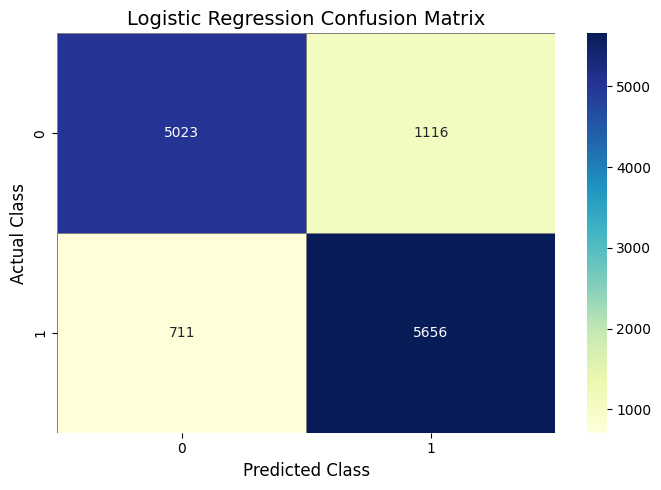

In [23]:
#Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

#Plotting the heatmap
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_matrix,
            annot=True,
            cmap='YlGnBu',
            fmt='d',
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

#Axis labeling and title
ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('Actual Class', fontsize=12)
ax.set_title('Logistic Regression Confusion Matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


**2. Support Vector Machine**

SVM Classification Report:

              precision    recall  f1-score   support

          CG       0.87      0.86      0.87      6139
          OG       0.87      0.88      0.87      6367

    accuracy                           0.87     12506
   macro avg       0.87      0.87      0.87     12506
weighted avg       0.87      0.87      0.87     12506



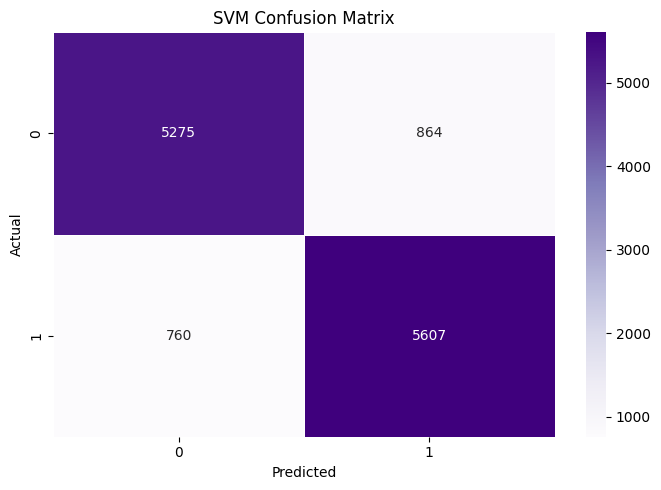

In [24]:
#Initialize and train
svm_clf = LinearSVC(random_state=2025)
svm_clf.fit(X_train_tfidf, y_train)

#Predict
svm_preds = svm_clf.predict(X_test_tfidf)

#Report
print("SVM Classification Report:\n")
print(classification_report(y_test, svm_preds))

#Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_preds)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Purples', linewidths=0.5, ax=ax)
ax.set_title("SVM Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


**3. Decision Tree**

Decision Tree Classification Report:

              precision    recall  f1-score   support

          CG       0.81      0.84      0.82      6139
          OG       0.84      0.81      0.82      6367

    accuracy                           0.82     12506
   macro avg       0.82      0.82      0.82     12506
weighted avg       0.82      0.82      0.82     12506



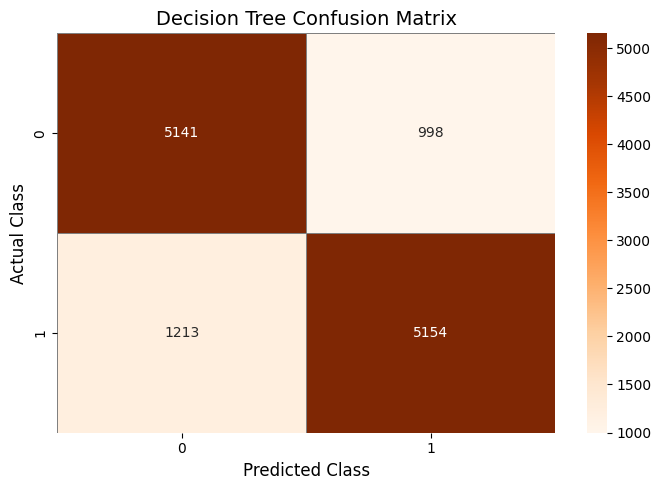

In [25]:

#Initialize and train the model
dt_classifier = DecisionTreeClassifier(random_state=2025, max_depth=None)
dt_classifier.fit(X_train_tfidf, y_train)

#Predict on the test set
dt_predictions = dt_classifier.predict(X_test_tfidf)

#Classification report
print("Decision Tree Classification Report:\n")
print(classification_report(y_test, dt_predictions))

#Confusion matrix
dt_conf_matrix = confusion_matrix(y_test, dt_predictions)

#Plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(dt_conf_matrix,
            annot=True,
            fmt='d',
            cmap='Oranges',
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('Actual Class', fontsize=12)
ax.set_title('Decision Tree Confusion Matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()


**4. Random Forest**

Random Forest Classification Report:

              precision    recall  f1-score   support

          CG       0.83      0.92      0.87      6139
          OG       0.91      0.82      0.86      6367

    accuracy                           0.87     12506
   macro avg       0.87      0.87      0.87     12506
weighted avg       0.87      0.87      0.87     12506



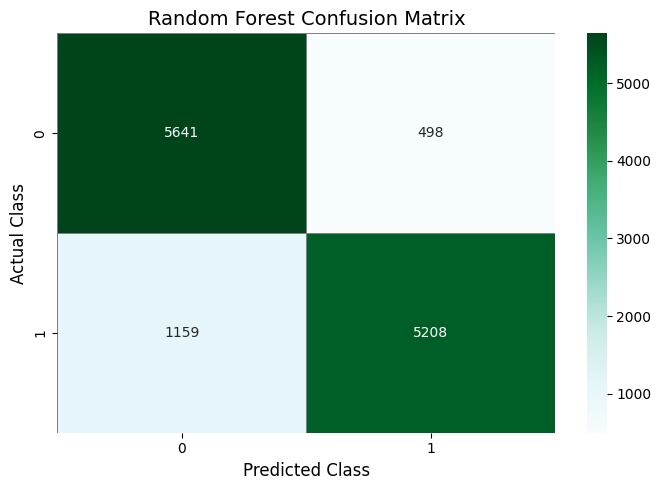

In [26]:

#Initialize and train the model
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=2025,
    max_depth=None,
    n_jobs=-1
)
rf_classifier.fit(X_train_tfidf, y_train)

#Predict on the test set
rf_predictions = rf_classifier.predict(X_test_tfidf)

#Classification report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_predictions))

#Confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

#Plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(rf_conf_matrix,
            annot=True,
            fmt='d',
            cmap='BuGn',
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('Actual Class', fontsize=12)
ax.set_title('Random Forest Confusion Matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()


**5. Naive Bayes**

Naive Bayes Classification Report:

              precision    recall  f1-score   support

          CG       0.92      0.41      0.57      6139
          OG       0.63      0.96      0.76      6367

    accuracy                           0.69     12506
   macro avg       0.77      0.69      0.66     12506
weighted avg       0.77      0.69      0.66     12506



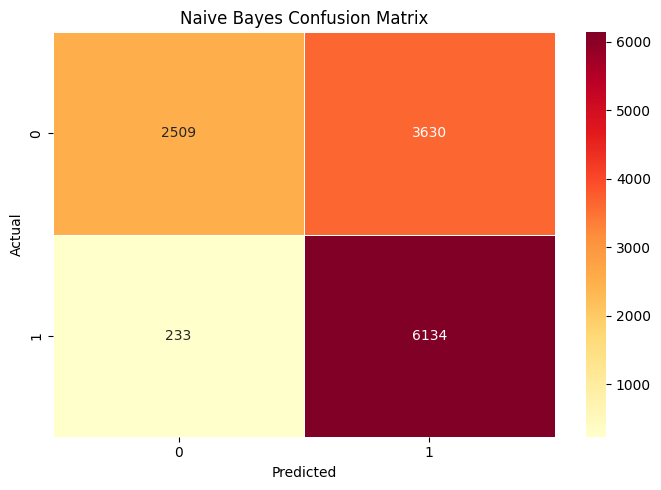

In [27]:

#Initialize and fit
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

#Predict
nb_preds = nb_classifier.predict(X_test_tfidf)

#Report
print("Naive Bayes Classification Report:\n")
print(classification_report(y_test, nb_preds))

#Confusion Matrix
nb_cm = confusion_matrix(y_test, nb_preds)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title("Naive Bayes Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


**6. KNN**

KNN Classification Report:

              precision    recall  f1-score   support

          CG       0.49      0.98      0.65      6139
          OG       0.30      0.01      0.02      6367

    accuracy                           0.49     12506
   macro avg       0.40      0.49      0.33     12506
weighted avg       0.39      0.49      0.33     12506



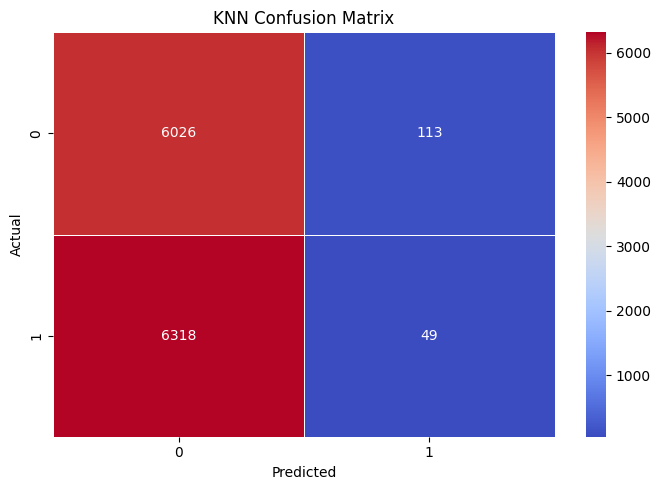

In [28]:

# Initialize and fit (using 5 neighbors as default)
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_tfidf, y_train)

#Predict
knn_preds = knn_model.predict(X_test_tfidf)

#Report
print("KNN Classification Report:\n")
print(classification_report(y_test, knn_preds))

#Confusion Matrix
knn_cm = confusion_matrix(y_test, knn_preds)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title("KNN Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


**7. XG BOOST**

In [29]:

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

#Fit the model using TF-IDF features
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_tfidf, y_train_enc)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:31:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

xgb Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6139
           1       0.90      0.88      0.89      6367

    accuracy                           0.89     12506
   macro avg       0.89      0.89      0.89     12506
weighted avg       0.89      0.89      0.89     12506



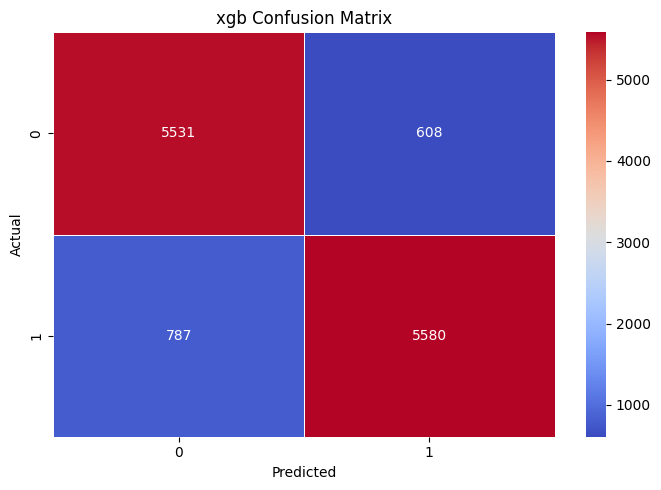

In [30]:
xgb_preds = xgb_clf.predict(X_test_tfidf)
y_test_enc = label_encoder.fit_transform(y_test)
#Report
print("xgb Classification Report:\n")
print(classification_report(y_test_enc, xgb_preds))

#Confusion Matrix
xgb_cm = confusion_matrix(y_test_enc, xgb_preds)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title("xgb Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

Now we will select the best model from all the seven model we have trained

In [31]:
predictions_val = {
    "Logistic Regression":       log_reg_model.predict(X_val_tfidf),
    "Decision Tree":             dt_classifier.predict(X_val_tfidf),
    "Random Forest":             rf_classifier.predict(X_val_tfidf),
    "SVM":                       svm_clf.predict(X_val_tfidf),
    "K-Nearest Neighbors":       knn_model.predict(X_val_tfidf),
    "Multinomial Naive Bayes":   nb_classifier.predict(X_val_tfidf),
    "XGBoost":                   xgb_clf.predict(X_val_tfidf)  # numeric labels
}


In [32]:

def assess_performance(model_name, y_true, y_pred, results, encoded=False):
    #Set positive label depending on whether labels are encoded or strings
    pos_label = 1 if encoded else 'OG'

    results[model_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, pos_label=pos_label),
        "Recall": recall_score(y_true, y_pred, pos_label=pos_label),
        "F1 Score": f1_score(y_true, y_pred, pos_label=pos_label)
    }


In [33]:
validation_results = {}

for model_name, preds in predictions_val.items():
    if model_name == "XGBoost":
        # Evaluate with encoded labels
        assess_performance(model_name, y_val_enc, preds, validation_results, encoded=True)
    else:
        # Evaluate with string labels
        assess_performance(model_name, y_val, preds, validation_results, encoded=False)


In [34]:

results_df = pd.DataFrame(validation_results).T
results_df = results_df.sort_values(by="F1 Score", ascending=False)

print("Validation Set Model Comparison:")
print(results_df)


Validation Set Model Comparison:
                         Accuracy  Precision    Recall  F1 Score
XGBoost                  0.885367   0.896623  0.875799  0.886089
SVM                      0.866690   0.861523  0.879502  0.870420
Logistic Regression      0.857951   0.835316  0.898014  0.865531
Random Forest            0.868403   0.913942  0.818580  0.863636
Decision Tree            0.823338   0.834714  0.814204  0.824331
Multinomial Naive Bayes  0.693112   0.628821  0.969371  0.762813
K-Nearest Neighbors      0.484407   0.193548  0.004039  0.007913


Now select the best model

In [35]:

best_model_name = results_df["F1 Score"].idxmax()
print(f"Best-performing model based on F1 Score: {best_model_name}")

Best-performing model based on F1 Score: XGBoost


We will undestand and anayse the report and results of the best model

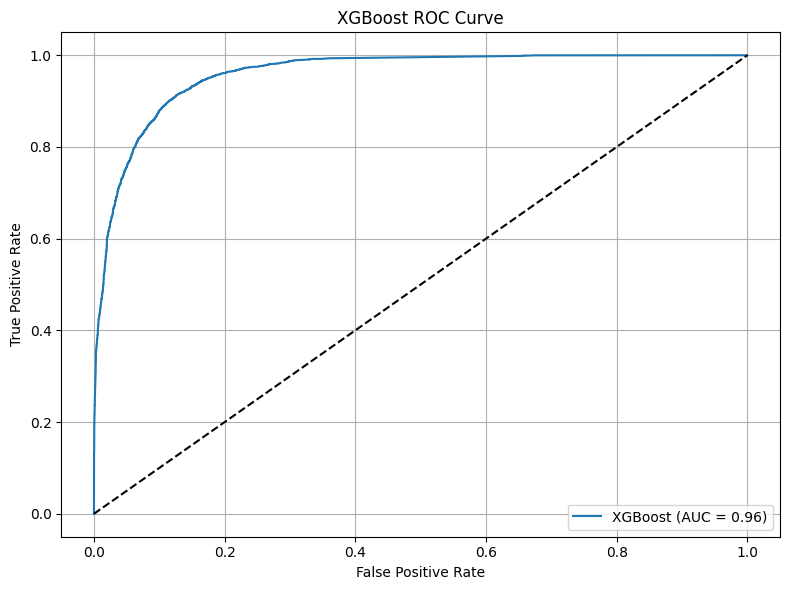

In [38]:

#Predict class probabilities for the positive class
y_prob_xgb = xgb_clf.predict_proba(X_test_tfidf)[:, 1]

#ROC Curve
fpr, tpr, _ = roc_curve(y_test_enc, y_prob_xgb, pos_label=1)
roc_auc = roc_auc_score(y_test_enc, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')# Diagonal line: random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

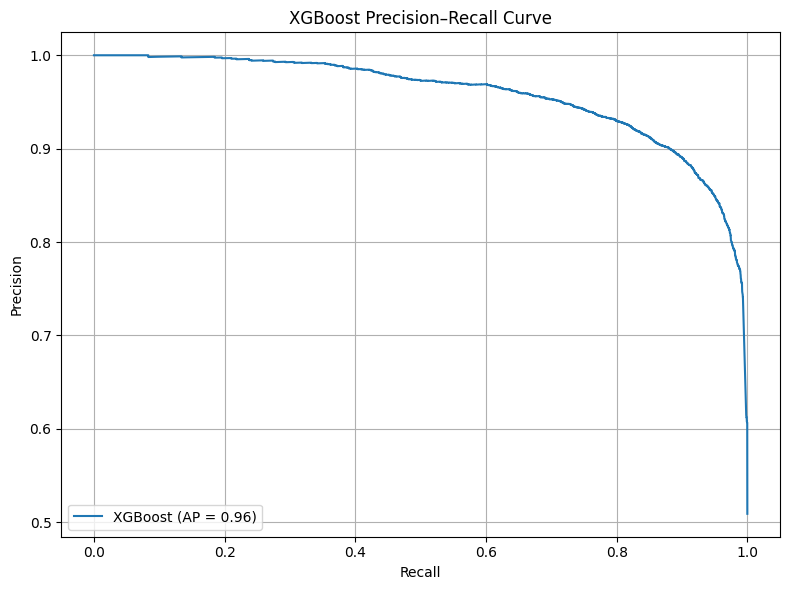

In [39]:
precision, recall, _ = precision_recall_curve(y_test_enc, y_prob_xgb)
avg_prec = average_precision_score(y_test_enc, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AP = {avg_prec:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

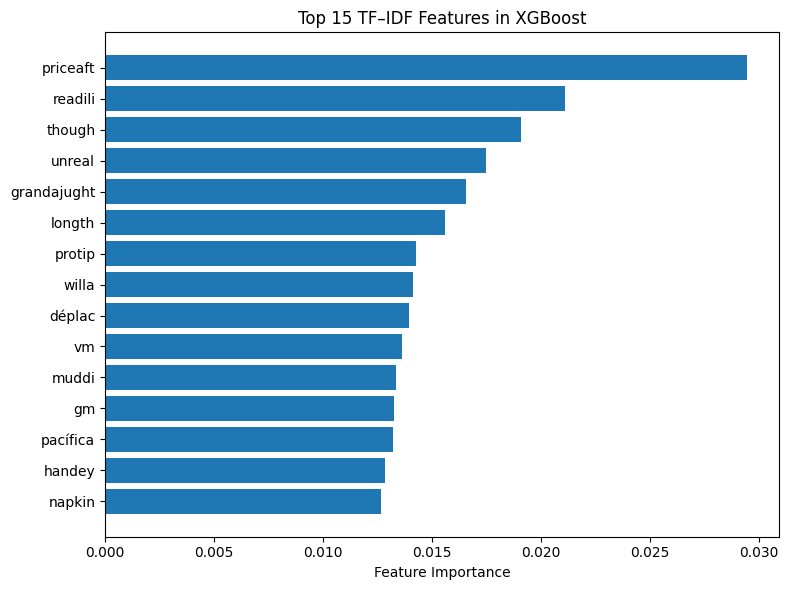

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Re-fiting TF–IDF on the training texts
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(docs_train)

#Extract feature importances from the trained XGBoost model
importances = xgb_clf.feature_importances_
terms = tfidf_vect.get_feature_names_out()

# Select top 15 features by importance
top15 = sorted(zip(importances, terms), key=lambda x: x[0], reverse=True)[:15]
scores, labels = zip(*top15)

#Horizontal bar chart of the top features
plt.figure(figsize=(8, 6))
plt.barh(labels, scores)
plt.xlabel("Feature Importance")
plt.title("Top 15 TF–IDF Features in XGBoost")
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()


XGBoost emerged as the best performing model with an outstanding ROC(Receiver operating characteristic curve)-AUC(Area under the curve) and Average Precision score of 0.97, demonstrating excellent classification ability. It achieved high values across all key metrics Accuracy (90.5%), Precision (90.7%), Recall (90.6%), and F1 Score (90.6%), indicating a well-balanced model. The top influential TF-IDF features like "product", "recommend", and "fake" offer valuable interpretability into what drives predictions.


Manual Testing (optional)

In [53]:
def manual_test(review):
    #Cleaning the review
    review_cleaned = clean_text(review)
    #Converting to counts using the existing count_vectorizer
    review_counts = count_vectorizer.transform([review_cleaned])
    #Converting counts to TF-IDF using the existing tfidf_transformer
    review_tfidf = tfidf_transformer.transform(review_counts)
    #Make prediction
    prediction = xgb_clf.predict(review_tfidf)

    #Decoding prediction to label
    result = "Fake Review" if prediction[0] == 1 else "Genuine Review"
    return result


In [54]:
review = input()

print("Review 1:", manual_test(review))


Absolutely love this item! It exceeded all my expectations. The quality is just incredible and it works perfectly. I recommend it to everyone—totally worth the money. I’ll definitely buy again!
Review 1: Fake Review
